A notebook to create the submission(s).

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    Stacked, SubstitutionOneHot, DNase, Classifier, Regression, RegressionClassifier
from utils import write_submission

## Load data

Read the training data with added conservation information.

In [2]:
training = pd.read_csv('data/cagi5_df.csv')
training.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Read the submission data

In [3]:
submission = pd.read_csv(
    'data/submission-with-cons.tsv',
    sep='\t',
    na_values='*')
submission.sample(6)

,Chrom,Pos,Ref,Alt,Promoter_Enhancer,Direction,P_Direction,Confidence,SE,Comments,phastCon,phyloP,GerpN,GerpRS
9627,10,51549285,G,A,MSMB,NaN,NaN,NaN,NaN,NaN,0.001,0.559,3.49,0.433
11112,19,11200105,C,A,LDLR,NaN,NaN,NaN,NaN,NaN,0.004,0.559,4.87,3.830
3683,1,209989468,T,A,IRF6,NaN,NaN,NaN,NaN,NaN,0.987,0.530,4.58,-1.140
3075,1,209989232,A,C,IRF6,NaN,NaN,NaN,NaN,NaN,0.874,0.530,4.45,3.330
6167,6,396529,G,A,IRF4,NaN,NaN,NaN,NaN,NaN,0.089,-0.264,3.98,-1.170
10154,11,5271077,G,T,HBG1,NaN,NaN,NaN,NaN,NaN,0.024,0.298,2.82,0.573


Identify all the submission regions to check they match those in the training data.

In [4]:
sub_regions = submission['Promoter_Enhancer'].unique()
sub_regions.sort()
print(sub_regions)
train_regions = training['regulatory_element'].str.slice(start=8).unique()
train_regions.sort()
print(train_regions)

['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB' 'MYC'
 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']
['F9' 'GP1BB' 'HBB' 'HBG1' 'HNF4A' 'IRF4' 'IRF6' 'LDLR' 'MSMB'
 'MYCrs6983267' 'PKLR' 'SORT1' 'TERT-GBM' 'TERT-HEK293T' 'ZFAND3']


TODO: Make sure that MYC region names match between training and submission data frames.

### Use tuned hyperparameters

These are taken from a kaggle kernel notebook

In [5]:
tuned_params={
    'max_depth': 2, #[3,4,5,6,7,8,9], # 5 is good but takes too long in kaggle env
    'subsample': 0.6, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': 0.5, #[0.5,0.6,0.7,0.8],
    'n_estimators': 1000, #[1000,2000,3000]
    'reg_alpha': 0.03 #[0.01, 0.02, 0.03, 0.04]
}

These are tuned by Bayesian optimisation (in another notebook)

In [6]:
tuned_params = {
    'colsample_bytree': 0.7524052235178577,
    'learning_rate': 0.39783003619093765,
    'max_depth': 7,
    'min_child_weight': 4.0467095559059505,
    'reg_alpha': 0.030682622499703896,
    'reg_lambda': 0.40505823486422077,
    'subsample': 1.0
}

### Choose features

In [7]:
def make_features(test):
    if test:
        stacked = Stacked('test-deep-dnase-cons')
        deepseadiffs = DeepSeaSNP(filename_fmt='deepsea-test_{}_preds.npy')
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11-test_{}_preds_v1.npy')
    else:
        stacked = Stacked('deep-dnase-cons')
        deepseadiffs = DeepSeaSNP(filename_fmt='deepsea_{}_preds.npy')
        ds500_dq = DeepSeaSNP(filename_fmt='ds500-dq-embed64-500-d20-3-5-11_{}_preds_v1.npy')
    dnase = DNase(test=test)
    conservation = Conservation()
    # subst = SubstitutionOneHot(test=test)
    # enhancer1hot = EnhancerOneHot(test=test)
    # snpcontext2 = SNPContext(context_size=2, test=test)
    # snpcontext4 = SNPContext(context_size=4, test=test)
    return MultiFeatures([deepseadiffs, dnase, conservation, stacked])
train_features = make_features(False)
test_features = make_features(True)

## Fit model

In [8]:
# import models, importlib
# importlib.reload(models)
# from models import Regression, Classifier, StackedRegressionClassifier
regression = Regression(train_features)
classifier = Classifier(train_features)
stacked = RegressionClassifier(regression, classifier)
X_train = stacked.get_features(training)
y_train = stacked.get_response(training)
stacked.fit(X_train, y_train)

/home/john/Dev/cagimpra/venv3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Make predictions

In [9]:
X_test = test_features.get_features(submission)
predictions = stacked.predict(X_test, submission.index)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb
9853,0.493333,0.104539,-1,0.085786,-0.239404,0.402128
1535,0.557969,0.424073,-1,0.418988,-0.929279,0.017957
7172,0.348515,0.250216,0,0.071764,-0.042101,0.401269
7462,0.306812,0.291630,0,0.039331,0.018154,0.401557
11452,0.239902,0.350612,0,0.053723,0.003588,0.409485
12233,0.295784,0.306320,0,0.057379,0.045585,0.397895


Call which variants are present from the regression predictions

In [10]:
# import models, importlib
# importlib.reload(models)
# from models import call_variants_from_regression
predictions = stacked.make_submission(predictions)
predictions.sample(6)

,NegativeProb,PositiveProb,PredClass,PredConfidence,PredValue,UncalledProb,Direction,P_Direction,Confidence,SE
4995,0.558504,0.174894,-1,0.497742,-0.865923,0.266601,-1,0.558504,0.497742,0.1
1675,0.679125,0.221426,-1,0.445417,-0.322769,0.099449,-1,0.679125,0.445417,0.1
5730,0.339013,0.229690,0,0.390820,-0.364533,0.431297,0,0.431297,0.390820,0.1
10514,0.404378,0.220105,-1,0.180698,-0.352589,0.375517,-1,0.404378,0.180698,0.1
2647,0.283233,0.466180,1,0.038537,-0.002284,0.250587,1,0.466180,0.038537,0.1
3274,0.292875,0.293146,0,0.051620,0.014868,0.413979,0,0.413979,0.051620,0.1


Plot the predicted values against the probability that they are correct coloured by called direction.

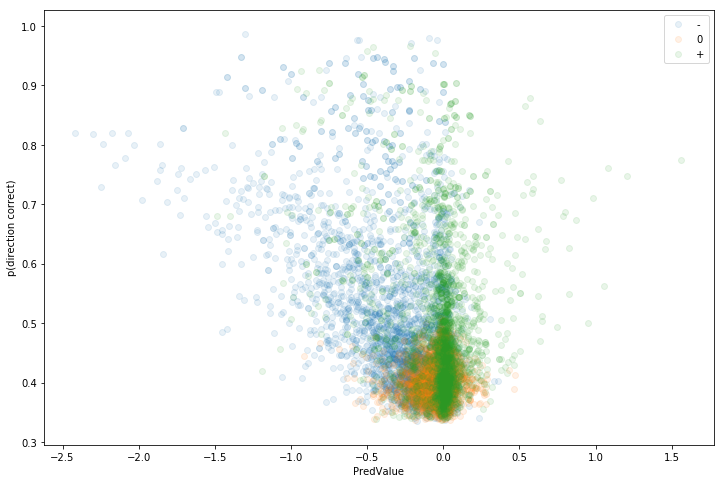

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
alpha = .1
neg = -1 == predictions['Direction']
zero = 0 == predictions['Direction']
pos =  1 == predictions['Direction']
ax.scatter(predictions.loc[neg, 'PredValue'], predictions.loc[neg, 'P_Direction'], label='-', alpha=alpha)
ax.scatter(predictions.loc[zero, 'PredValue'], predictions.loc[zero, 'P_Direction'], label='0', alpha=alpha)
ax.scatter(predictions.loc[pos, 'PredValue'], predictions.loc[pos, 'P_Direction'], label='+', alpha=alpha)
ax.legend()
ax.set_xlabel('PredValue')
ax.set_ylabel('p(direction correct)')
None

## Load confidence standard errors

In [22]:
conf_se = np.load('data/conf-se.npy')
predictions['SE'] = conf_se

### Save predictions

In [27]:
# import utils, importlib
# importlib.reload(utils)
for col in ['Direction', 'P_Direction', 'Confidence', 'SE']:
    submission[col] = predictions[col]
submission['Comments'] = '*'
write_submission(submission, 'data/submission-1.txt')

Writing submission to: data/submission-1.txt
